In [71]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tqdm import tqdm
import math
import re
%matplotlib inline

In [72]:

silly = pd.read_csv("./" + "mechbull" + ".csv", delimiter=",",)


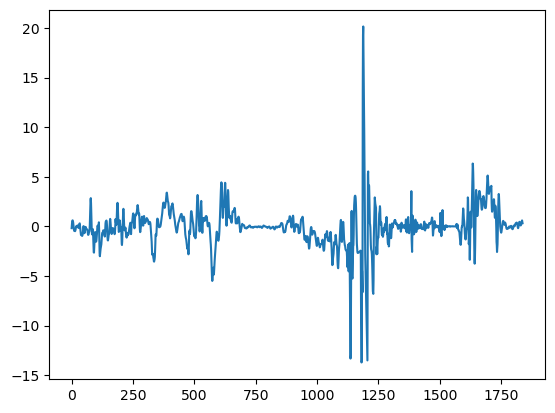

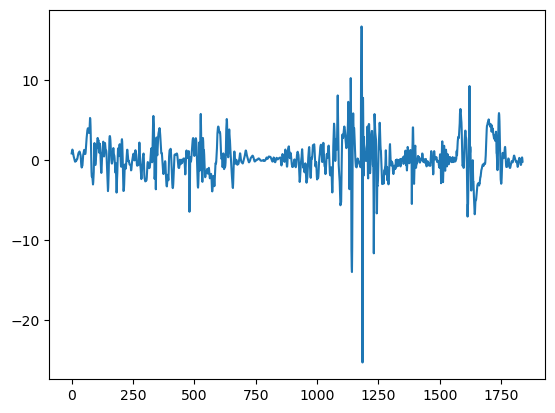

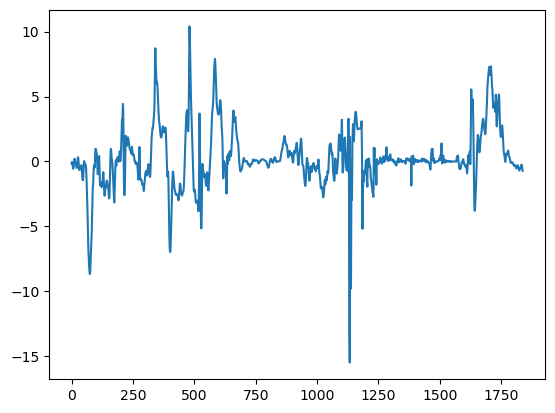

In [82]:
time = silly["Time (s)"][2:len(silly["Time (s)"])].to_numpy()
xa = silly["Gyroscope x (rad/s)"][2:len(silly["Gyroscope x (rad/s)"])].to_numpy()
ya = silly["Gyroscope y (rad/s)"][2:len(silly["Gyroscope y (rad/s)"])].to_numpy()
za = silly["Gyroscope z (rad/s)"][2:len(silly["Gyroscope z (rad/s)"])].to_numpy()


plt.figure()
plt.plot(xa)

plt.figure()
plt.plot(ya)

plt.figure()
plt.plot(za)

xa=xa[0:1000]
ya=ya[0:1000]
za=za[0:1000]

In [83]:
xv=sp.integrate.cumtrapz(xa)
xd=sp.integrate.cumtrapz(xv)


yv=sp.integrate.cumtrapz(ya)
yd=sp.integrate.cumtrapz(yv)



zv=sp.integrate.cumtrapz(za)
zd=sp.integrate.cumtrapz(zv)

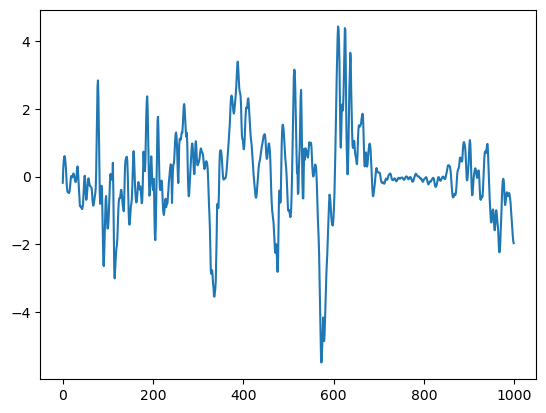

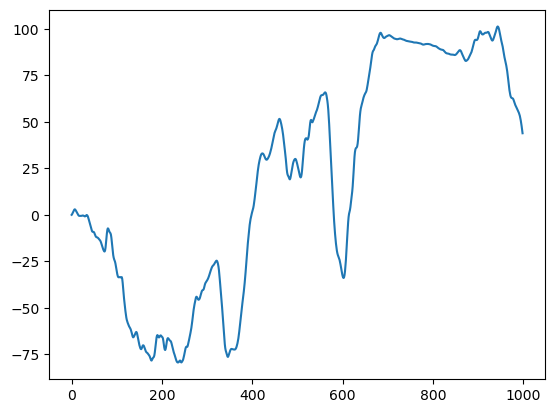

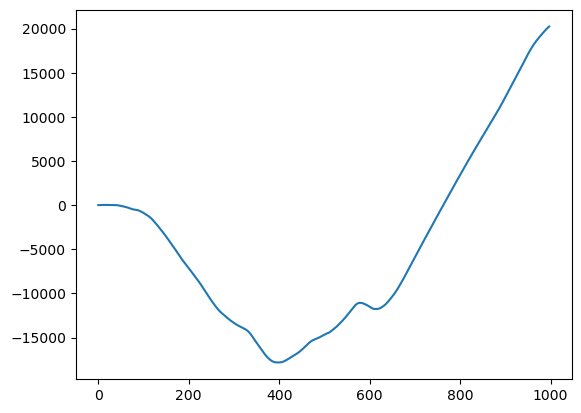

In [84]:


plt.figure()
plt.plot(xa)
plt.figure()
plt.plot(xv)
plt.figure()
plt.plot(xd)

Text(0.5, 1.0, 'Y displacement')

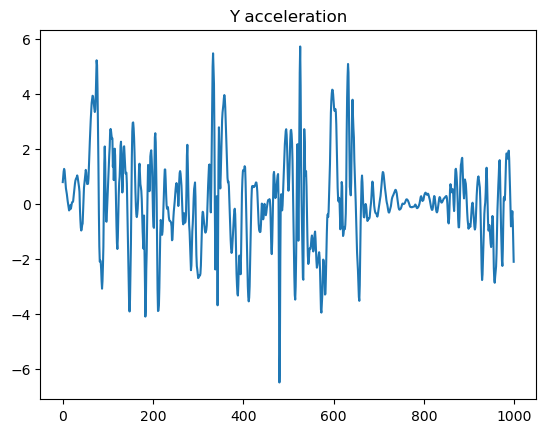

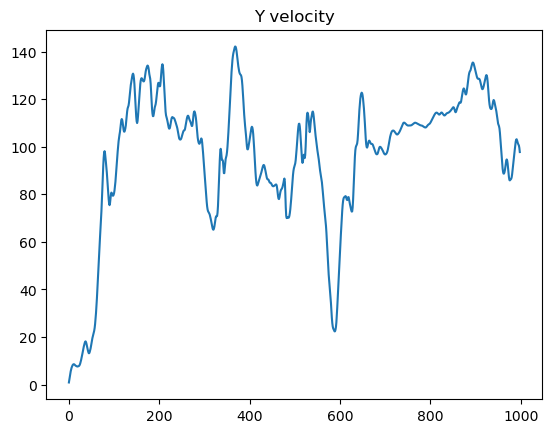

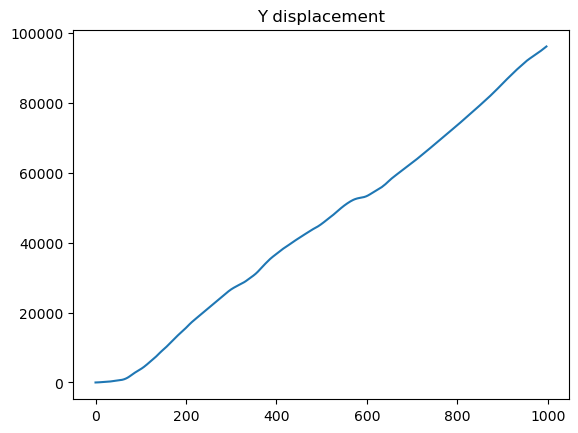

In [85]:


plt.figure()
plt.plot(ya)
plt.title("Y acceleration")
plt.figure()
plt.plot(yv)
plt.title("Y velocity")
plt.figure()
plt.plot(yd)
plt.title("Y displacement")

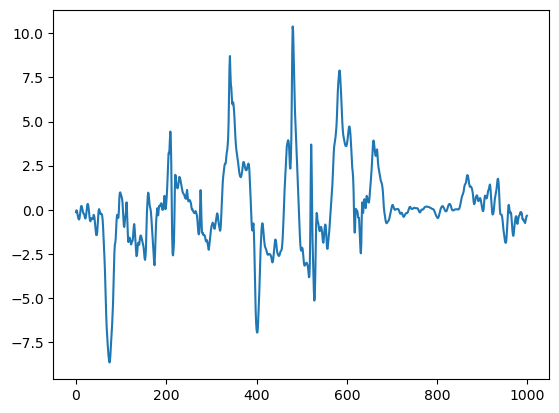

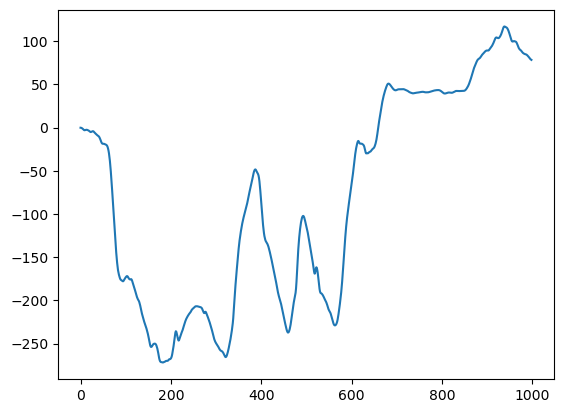

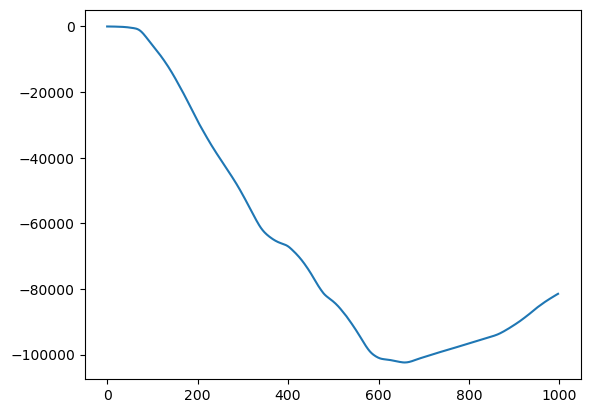

In [86]:


plt.figure()
plt.plot(za)
plt.figure()
plt.plot(zv)
plt.figure()
plt.plot(zd)

In [87]:
def gen_rot_mat(angles):
    """
    Helper function, Given roll, pitch and yaw , generates a rotation matrix
    inputs:
        angles--a 3x 1 roll pitch and yaw vector [roll,pitch,yaw] in degrees
    outputs:
        tuple with (roll,pitch, yaw), where roll, pitch, and yaw are 3x3 matrices
    """
    assert isinstance(angles, np.ndarray), "angles in gen_rot_mat is not a numpy array"
    angles_rad=np.deg2rad(angles)
    pitch,roll,yaw=tuple(angles_rad)
    yaw_mat=np.array([
        [np.cos(yaw) , np.sin(yaw),0],
        [-np.sin(yaw),np.cos(yaw) ,0],
        [0           ,0           ,1]
    ])
    pitch_mat=np.array([
        [np.cos(pitch),0,-np.sin(pitch)],
        [0            ,1,       0      ],
        [np.sin(pitch),0, np.cos(pitch)]
    ])
    roll_mat=np.array([
        [1,     0       ,       0    ],
        [0,np.cos(roll) ,np.sin(roll)],
        [0,-np.sin(roll),np.cos(roll)]
    ])
    return (roll_mat,pitch_mat,yaw_mat)

def gen_rot_mat_vec(angles_list):
    """
    generates a tuple containing the pitch, roll, and yaw lists of rotation matrices for each 
    angle in angles_list
    _                                                 _
    | [a11 a12 a13]  [a21 a22 a23]  ... [an1 an2 an3]  |
    | [a14 a15 a16]  [a24 a25 a26]  ... [an4 an5 an6]  |
    | [a17 a18 a19], [a27 a28 a29], ... [an7 an8 an9]  |
    -                                                  -

    inputs: 
        angles_list--a 3xN matrix containing rolls pitches and yaws. List of N 3x1 angle vectors
    outputs:
        tuple with (roll,pitch, yaw), where roll, pitch, and yaw are NX3x3 matrices
    """

    num_e=len(angles_list)
    angles_list_rad=np.deg2rad(angles_list)
    pitch_list=angles_list_rad[:,0]
    yaw_list=angles_list_rad[:,2]
    roll_list=angles_list_rad[:,1]

    pitch_mats=np.zeros((len(angles_list),3,3))
    roll_mats=np.zeros((len(angles_list),3,3))
    yaw_mats=np.zeros((len(angles_list),3,3))
    
    yaw_mats[:,0,:]=np.array([np.cos(yaw_list),np.sin(yaw_list),np.zeros(len(yaw_list))]).T
    yaw_mats[:,1,:]=np.array([-np.sin(yaw_list),np.cos(yaw_list),np.zeros(len(yaw_list))]).T
    yaw_mats[:,2,:]=np.array([np.zeros(num_e),np.zeros(num_e),np.ones(num_e)]).T

    pitch_mats[:,0,:]=np.array([np.cos(pitch_list),np.zeros(num_e),-np.sin(pitch_list)]).T
    pitch_mats[:,1,:]=np.array([np.zeros(num_e),np.ones(num_e),np.zeros(num_e)]).T
    pitch_mats[:,2,:]=np.array([np.sin(pitch_list),np.zeros(num_e),np.cos(pitch_list)]).T

    roll_mats[:,0,:]=np.array([np.ones(num_e),np.zeros(num_e),np.zeros(num_e)]).T
    roll_mats[:,1,:]=np.array([np.zeros(num_e),np.cos(roll_list),np.sin(roll_list)]).T
    roll_mats[:,2,:]=np.array([np.zeros(num_e), -np.sin(roll_list),np.cos(roll_list)]).T

    return (roll_mats, pitch_mats,yaw_mats)

def drone2NED_vec(drone_angles_list,drone_vector_list):
    """
    Helper function, convert from local drone NED coordinates(accounting for drone rotation) to drone centered GPS aligned NED coordinates over multiple time steps
    inputs:
        drone_angles_list--a list containing N entries of 3x1 roll, pitch, anf yaw readout vectors from telemetry. An Nx3 matrix
        drone_vector_list--a list containing N entries of 3x1 N,E,D coordinates in the drone centered, drone aligned coordinate system. An Nx3 matrix

    outputs:
        drone_vectors--a list containing N entries for 3x1 x,y,z coordinates in the drone centered, GPS aligned coordinate system. An Nx3 matrix
    """
    #total number of angles needs to equal to the number of vectors in drone_vector_list, as each
    #angle in drone_angles_list is associated with drone telemetry when a measurement is made
    drone_angles_list=-1*drone_angles_list
    roll_mats,pitch_mats,yaw_mats=gen_rot_mat_vec(drone_angles_list)
    
    drone_vectors=np.einsum('abc,acd,ade,ae->ab',yaw_mats,pitch_mats,roll_mats,drone_vector_list) #witchcraft. not sure why ab instead of ae
    
    return drone_vectors


angle_list_a=np.zeros((len(xa),3))

angle_list_v=np.zeros((len(xv),3))

angle_list_d=np.zeros((len(xd),3))


arm_list_a=np.zeros((len(xa),3))
arm_list_a[:,2]=-1

arm_list_v=np.zeros((len(xv),3))
arm_list_v[:,2]=-1

arm_list_d=np.zeros((len(xd),3))
arm_list_d[:,2]=-1



angle_list_a[:,0]=xa
angle_list_a[:,1]=ya
angle_list_a[:,2]=za


angle_list_v[:,0]=xv
angle_list_v[:,1]=yv
angle_list_v[:,2]=zv


angle_list_d[:,0]=xd
angle_list_d[:,1]=yd
angle_list_d[:,2]=zd

#angle_list_a=np.array([xa,ya,za])

#rotx,roty,rotz=gen_rot_mat_vec(angle_list_a)

vecs_a=drone2NED_vec(angle_list_a,arm_list_a)
vecs_v=drone2NED_vec(angle_list_v,arm_list_v)
vecs_d=drone2NED_vec(angle_list_d,arm_list_d)



Text(0.5, 0.92, 'Acceleration')

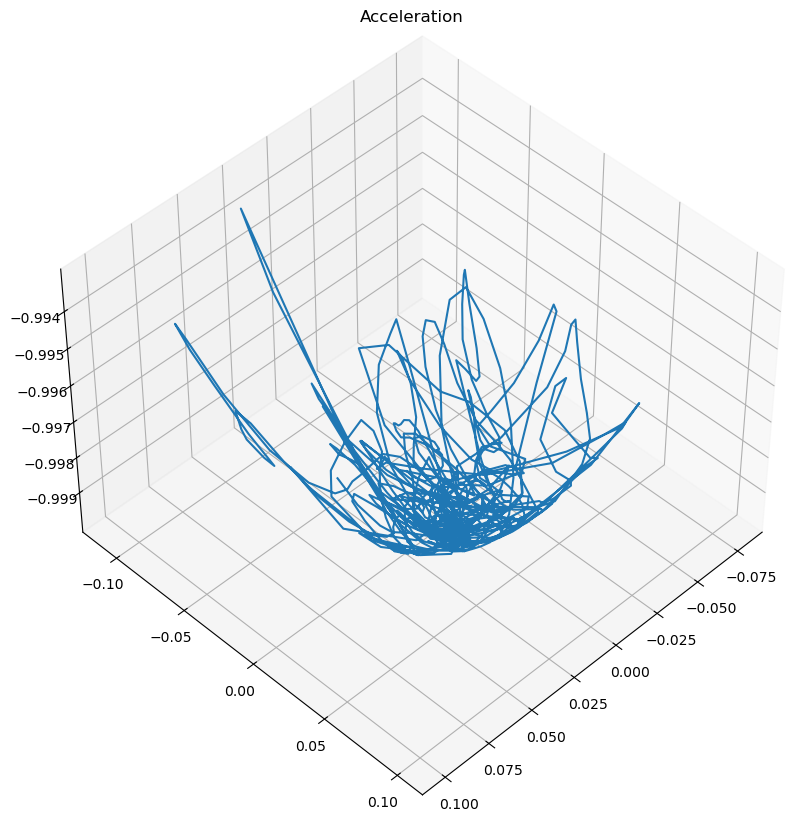

In [91]:
view_angles=[45,45,0]
ax=plt.figure(figsize=(10,10)).add_subplot(projection='3d')
ax.view_init(elev=view_angles[0], azim=view_angles[1], roll=view_angles[2])
plt.plot(vecs_a[:,0],vecs_a[:,1],vecs_a[:,2])
plt.title("Acceleration")

Text(0.5, 0.92, 'Velocity')

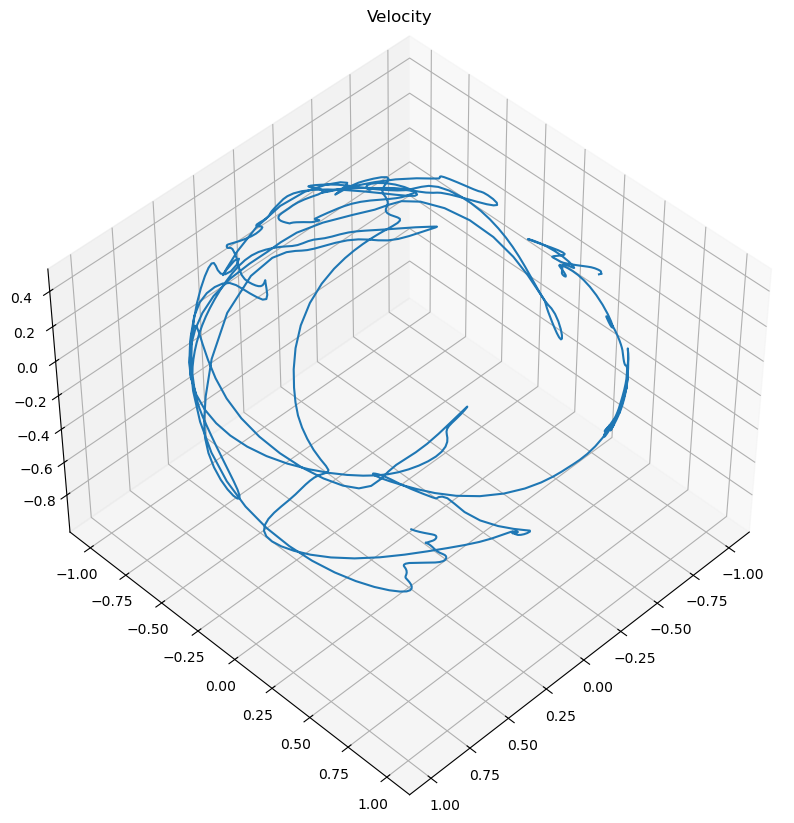

In [92]:
view_angles=[45,45,0]
ax=plt.figure(figsize=(10,10)).add_subplot(projection='3d')
ax.view_init(elev=view_angles[0], azim=view_angles[1], roll=view_angles[2])
plt.plot(vecs_v[:,0],vecs_v[:,1],vecs_v[:,2])
plt.title("Velocity")

Text(0.5, 0.92, 'Displacement')

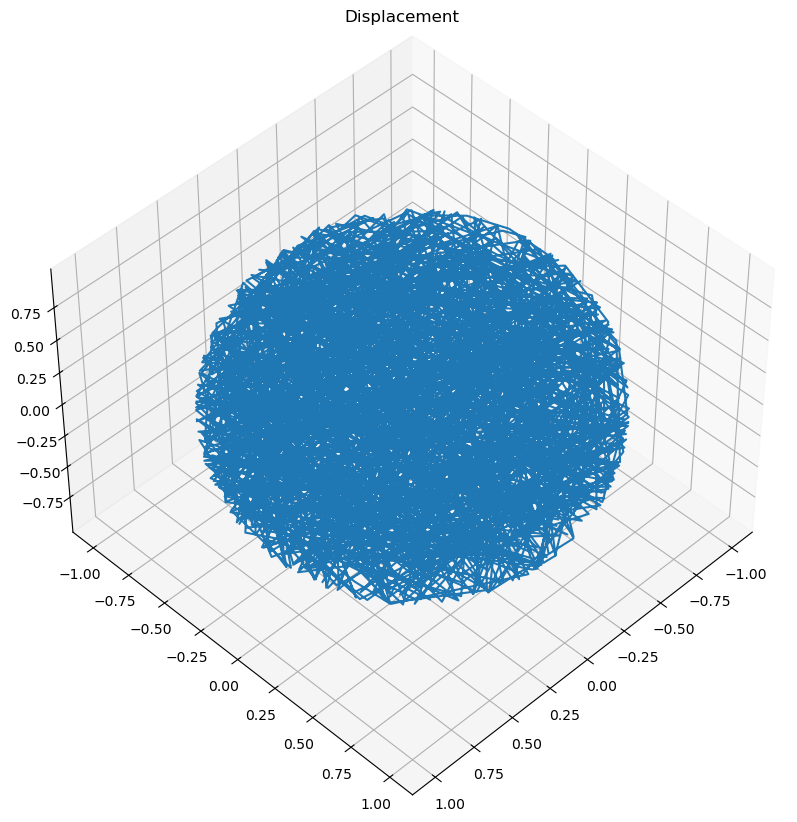

In [93]:
view_angles=[45,45,0]
ax=plt.figure(figsize=(10,10)).add_subplot(projection='3d')
ax.view_init(elev=view_angles[0], azim=view_angles[1], roll=view_angles[2])
plt.plot(vecs_d[:,0],vecs_d[:,1],vecs_d[:,2])
plt.title("Displacement")